<h2>Multilabel classification - digit recognition</h2>
By <a href="https://movsisyan.info/">Mher Movsisyan</a> and <a href="https://www.linkedin.com/in/tigran-avetisyan/">Tigran Avetisyan</a>

1. <a href="https://www.kaggle.com/movsisyanm/mnist-custom-dataset-cnn-classification#1">Importing Tools and Data</a>
2. <a href="https://www.kaggle.com/movsisyanm/mnist-custom-dataset-cnn-classification#2">Joining Data</a>
3. <a href="https://www.kaggle.com/movsisyanm/mnist-custom-dataset-cnn-classification#3">Creating Custom Layer and Callback</a>
4. <a href="https://www.kaggle.com/movsisyanm/mnist-custom-dataset-cnn-classification#4">Importing Tools and Data</a>


<h2 id="1">1 - Importing Tools and Data</h2>

In [1]:
! pip install keract

import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras import backend as K
import matplotlib.pyplot as plt
from keras.models import Sequential
import matplotlib.patches as patches
from skimage.filters import threshold_otsu
from keras.optimizers import RMSprop, SGD, Adam
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from keract import get_activations, display_activations
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
from keras.layers.experimental.preprocessing import RandomTranslation, RandomRotation, RandomWidth, RandomHeight, RandomZoom, Resizing
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPool2D, BatchNormalization, Reshape, GlobalAveragePooling2D, LeakyReLU, Layer, Concatenate, Input

seed = 173
np.random.seed(seed)
tf.random.set_seed(seed)

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3832177196828706325
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15683598464
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14609993107732398950
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


In [2]:
df = pd.read_csv("../input/digits-mini-dataset-5500/drawings_non_binary.csv")
mnist = pd.read_csv("../input/digit-recognizer/train.csv")
df

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5505,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
5506,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
5507,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
5508,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9


<h2 id="2">2 - Joining Data</h2>

In [3]:
joint = pd.DataFrame(mnist.iloc[:, 1:].to_numpy())
joint["label"] = mnist.label
jointDf = pd.DataFrame(np.concatenate((joint, df), axis=0)).rename({784: "label"}, axis=1).sample(frac=1, random_state=seed)

Making sure the classes are balanced

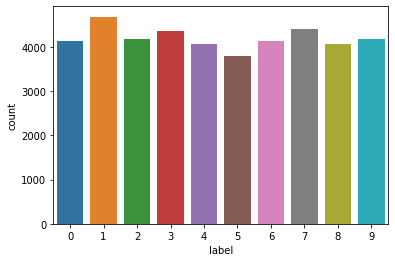

In [4]:
sns.countplot(x = joint.label);

One-hot encoding labels

In [5]:
y = to_categorical(jointDf.label)

Extracting inference and holdout datasets

In [6]:
x_train, x_test, y_train, y_test = train_test_split(jointDf.iloc[:,:-1], y, train_size=0.9, random_state=seed) # no need to stratify for large balanced datasets
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((42759, 784), (4751, 784), (42759, 10), (4751, 10))

Displaying a random observation

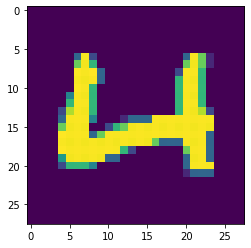

In [7]:
plt.imshow(np.array(x_test.sample(1, random_state=seed)).reshape(28, 28));

<h2 id="3">Creating Custom Layer and Callback</h2>

Creating a custom callback for the convolutional neural network.   
This callback works like the inverse of ReduceLROnPlateau. In case the model converges to a local minimum, the GateOfLearning callback kicks the learning rate up to help it overcome barriers and hopefully converge to a global minimum.
  
  
Guess where the name is from :D

In [8]:
class GateOfLearning(Callback):
    """Increases learning rate when stuck at extrema, a friend to ReduceLROnPlateau, ModelCheckpoint callbacks.\n

    \n
    Args:\n
        `monitor`: quantity to be monitored.\n
        `factor`: factor by which the learning rate will be reduced. Must be multitudes greater than that of the ReduceLROnPlateau\n
            `new_lr = lr * factor`.\n
        `patience`: number of epochs with no improvement after which learning rate will be increased. Must be greater \
            than that of the ReduceLROnPlateau `(6 by default)`\n
        `verbose`: int. 0: quiet, 1: update messages. `(1 by default)`\n
        `mode`: one of `{'min', 'max'}`. In `'min'` mode, the learning rate will be increased when the quantity\
             monitored has stopped decreasing; in `'max'` mode it will be increased when the quantity monitored has stopped increasing.\n
        `cooldown`: number of epochs to wait before resuming normal operation afterlr has been reduced. `(0 by default)`\n
        `max_lr`: upper bound on the learning rate. `(initial value * 50 by default)`\n
    """

    def __init__(self, monitor="val_loss", factor=15.0, patience=6, verbose=1, mode="min", cooldown=0, max_lr=999):
        # Sanity check
        if factor <= 1.0:
            raise ValueError(
                "GateOfLearning does not support a factor <= 1.0.")

        if mode not in ["min", "max"]:
            raise ValueError(
                f"GateOfLearning does not support a mode '{mode}'. Use 'min' or 'max' instead.")

        # Init
        super(GateOfLearning, self).__init__()
        self.monitor = monitor
        self.factor = factor
        self.patience = patience
        self.verbose = verbose
        self.objective = min if mode == "min" else max
        self.cooldown = cooldown
        self.max_lr = max_lr

        self.backup = (monitor, factor, patience,
                       verbose, mode, cooldown, max_lr)

        self.observations = []
        self.lr_history = []
        self.last_opened = 0

    def _reset(self):
        """Reset state"""
        self.monitor, self.factor, self.patience, self.verbose, self.mode, self.cooldown, self.max_lr = self.backup

        self.observations = []
        self.lr_history = []
        self.last_opened = 0

    def on_train_begin(self, logs=None):
        """Training start handler"""
        self._reset()

    def open_gate(self):
        """Increases learning rate"""
        new_lr = self.lr_history[-1] * self.factor

        assert new_lr > self.lr_history[-1], f"old: {self.lr_history[-1]}, new: {new_lr}"

        if new_lr > self.max_lr:

            if self.verbose:
                print("Learning rate diverged. You can solve this problem by using a faster ReduceLROnPlateau, \
                    a smaller factor, or a bigger patience/cooldown. Make sure the objective is appropriate.")
        else:
            old_lr = float(self.model.optimizer.learning_rate)
            self.model.optimizer.learning_rate = new_lr
            if self.verbose:
                print(
                    f"\nGateOfLearning: Learning rate increased from {old_lr} to {float(self.model.optimizer.learning_rate)}")

    def on_epoch_end(self, epoch, logs=None):
        """Epoch end handler"""
        # Log learning rate.
        self.lr_history.append(logs["lr"])

        # Set the maximum learning rate to the initial or otherwise specified maximum learning rate
        if len(self.lr_history) <= 1:
            self.max_lr = min(self.max_lr, 50 * self.lr_history[0])

        # Check if the metric is reported, otherwise use default metrics.
        if self.monitor not in logs.keys():
            initMetric = self.monitor
            self.monitor = "val_loss" if "val_loss" in logs.keys() else "loss"
            if self.verbose:
                print(
                    f"\nGateOfLearning: The '{initMetric}' metric was never reported. Using '{self.monitor}' instead.\n")

        # Log metric
        self.observations.append(logs[self.monitor])

        # Check if it is too early for an opening
        if len(self.observations) <= self.patience:
            return

        # Check if there is no improvement
        if self.objective(self.observations[-self.patience:]) == self.observations[-self.patience]:
            if epoch - self.last_opened > self.cooldown:
                self.open_gate()
                self.last_opened = epoch
                self.observations = [self.observations[-self.patience]]

In [9]:
class SingularityExtractor2D(Layer):
    """
    Accentuates pixels that differ from its surrounding pixels. 
    """

    def __init__(self, degree=6, kernel_size=3, padding="SYMMETRIC", margin=1, **kwargs):
        if not ((kernel_size % 2) and kernel_size >= 3 and isinstance(kernel_size, int)):
            raise ValueError("kernel_size: value must be odd, >= 3")

        if not (margin >= 1 and isinstance(margin, int)):
            raise ValueError("margin: must be integer >= 1")

        if padding not in ["CONSTANT", "SYMMETRIC", "REFLECT"]:
            raise ValueError(
                "padding: must be one of ['CONSTANT', 'SYMMETRIC', 'REFLECT']")

        self.degree = degree
        self.kernel_size = kernel_size
        self.padding = padding
        self.margin = margin

        self.radius = int((kernel_size - 1)/2)
        
        if "trainable" in kwargs.keys():
            super(SingularityExtractor2D, self).__init__(**kwargs)
        else:
            super(SingularityExtractor2D, self).__init__(trainable = False, **kwargs)

    # region Keras api

    def build(self, input_shape):
        if len(input_shape) != 4:
            raise ValueError("input must be 4D (batch_size, x, y, channels)")

        super(SingularityExtractor2D, self).build(input_shape)

        # Lazy load conv kernel
        # Hard-coded 1-channel for the digit-recognizer project,
        # will (hopefully) change after
        # , dtype=self.dtype)
        self.ones = tf.ones((self.kernel_size, self.kernel_size, 1, 1))

    def get_config(self):
        """Layer to dict = serializability"""

        config = super(SingularityExtractor2D, self).get_config()
        print(config)
        config["degree"] = self.degree
        config["kernel_size"] = self.kernel_size
        config["padding"] = self.padding
        config["margin"] = self.margin
        config["dtype"] = self.dtype

        return config

    @classmethod
    def from_config(cls, config):
        return cls(
            config["degree"],
            config["kernel_size"],
            config["padding"],
            config["margin"],
            dtype=config["dtype"]
        )

    def call(self, input_data):
        return self.extract(input_data, "keras")

    def compute_output_shape(self, input_shape):
        return (input_shape[-3], input_shape[-2] - 2 * self.margin, input_shape[-1] - 2 * self.margin, 1)

    def compute_output_signature(self, input_spec):
        shape = (input_spec.shape[-3], input_spec.shape[-2] - 2 *
                 self.margin, input_spec.shape[-1] - 2 * self.margin, 1)
        return tf.TensorSpec(shape, self.dtype)

    # endregion Keras api

    # region Scikit api

    def fit(self, x, *args, **kwargs):
        if len(x.shape) != 4:
            raise ValueError(
                "input must be 4D (number_of_observations, x, y, 1)")

    def transform(self, input_data, *args, **kwargs):
        return self.extract(input_data, "sk")

    # endregion Scikit api

    def extract(self, input_data, api):
        if api == "sk":
            self.extract(input_data, "keras").numpy()
        else:
            # Pad the incoming tensor
            matpad = tf.pad(input_data, [
                [0, 0],
                [self.radius, self.radius],
                [self.radius, self.radius],
                [0, 0]
            ], mode=self.padding)

            # Sum all the pixels in the kernel
            conv = tf.nn.convolution(matpad, self.ones, 1, padding="SAME")

            # Calculate the change in shape
            mrgn_0 = int((conv.shape[1] - input_data.shape[1])/2) + self.margin
            mrgn_1 = int((conv.shape[2] - input_data.shape[2])/2) + self.margin

            # Select appropriate regions
            selection_conv = conv[:, mrgn_0:-mrgn_0, mrgn_1:-mrgn_1, :]
            selection_input = input_data[:, self.margin:-
                                         self.margin, self.margin:-self.margin, :]

            # Compute the output
            return ((selection_conv - selection_input) / selection_conv) ** self.degree


<h2 id="4">4 - Building the model:</h2>

In [10]:
class PreprocessingBlock(Layer):
    """Preprocessing block (width, translation, zoom, seed=173)"""

    def __init__(self, width, translation, zoom, seed=173):
        super(PreprocessingBlock, self).__init__()
        self.w, self.t, self.z, self.s = width, translation, zoom, seed
        self.reshape = Reshape((28, 28, 1))
        self.width = RandomWidth(width, seed=seed, interpolation="bicubic")
        self.translation = RandomTranslation(
            *translation, seed=seed, fill_mode="constant", fill_value=0)
        self.zoom = RandomZoom(*zoom, seed=seed)
        self.resize = Resizing(28, 28, interpolation="bicubic")

    def call(self, input_data, training=None):
        x = self.reshape(input_data)

        if training:
            x = self.width(x)
            x = self.translation(x)
            x = self.zoom(x)
            x = self.resize(x)

        return x
    
    def get_config(self):
        config = super(PreprocessingBlock, self).get_config()
        config["width"] = self.w
        config["translation"] = self.t
        config["zoom"] = self.z
        config["seed"] = self.s
        
        return config
        
    @classmethod
    def from_config(cls, config):
        cls(**config)

In [11]:
class ConvBlock(Layer):
    """A block of convolutional layers"""

    def __init__(self, units, kernel_size, depth, pool=False, seed=173):
        super(ConvBlock, self).__init__()
        self.units = units
        self.kernel_size = kernel_size
        self.depth = depth
        self.pool = pool
        self.seed = seed
        self.layers = []

        for i in range(depth - 1):
            self.layers.append(
                Conv2D(units, kernel_size=kernel_size, padding="same", activation="relu"))
            self.layers.append(BatchNormalization(axis=1))

        if pool:
            self.layers.append(
                Conv2D(units, kernel_size=kernel_size, padding="same", activation="relu"))
            self.layers.append(MaxPool2D())
        else:
            self.layers.append(Conv2D(
                units, kernel_size=kernel_size, padding="same", strides=2, activation="relu"))

    def call(self, input_data):
        out = input_data
        for layer in self.layers:
            out = layer(out)
        return out
    
    def get_config(self):
        config = super(ConvBlock, self).get_config()
        config["units"] = self.units
        config["kernel_size"] = self.kernel_size
        config["depth"] = self.depth
        config["pool"] = self.pool
        config["seed"] = self.seed
        
        return config
        
    @classmethod
    def from_config(cls, config):
        cls(**config)
        

In [24]:
def get_model(seed=173):
    """Generate MSXCN"""
    
    x = Input((28 * 28))
    y = PreprocessingBlock(0.18, (0.14, 0.2), ((-0.05, -0.1), (-0.05, -0.02)), seed=seed)(x)


    # Convolutional chain
    y_0 = ConvBlock(32, 5, 2, True, seed=seed)(y)
    y_0 = BatchNormalization(axis=1)(y_0) # Some papers suggest to stay away from
    y_0 = Dropout(0.3, seed=seed)(y_0)    # using batch-norm and dropout together
                                          # https://link.springer.com/article/10.1007/s11042-019-08453-9
        
    y_0 = ConvBlock(64, 5, 2, True, seed=seed)(y_0)
    y_0 = BatchNormalization(axis=1)(y_0)
    y_0 = Dropout(0.3, seed=seed)(y_0)

    
    y_0 = ConvBlock(128, 5, 2, True, seed=seed)(y_0)
    y_0 = GlobalAveragePooling2D()(y_0)
    y_0 = Flatten()(y_0)
    y_0 = BatchNormalization(axis=1)(y_0)
    y_0 = Dropout(0.4, seed=seed)(y_0)
    y_0 = Dense(512, activation="relu")(y_0)
    

    # Singularity Extractor chain 1
    y_1 = SingularityExtractor2D(7, 3, margin=2, trainable=False)(y)
    y_1 = MaxPool2D()(y_1)
    y_1 = Flatten()(y_1)
    y_1 = Dense(64, activation="relu")(y_1)



    # Cognitive block
    y = Concatenate()([y_0, y_1])

    y = Dense(512)(y)
    y = LeakyReLU(0.1)(y)
    y = BatchNormalization(axis=1)(y)
    y = Dropout(0.6, seed=seed)(y)

    y = Dense(256, activation="tanh")(y)
    y = BatchNormalization(axis=1)(y)
    y = Dropout(0.6, seed=seed)(y)

    y = Dense(10, activation="softmax")(y)

    opt = RMSprop(learning_rate = 0.002, decay = 0)
    model = tf.keras.Model(x, y)
    model.compile(opt, "categorical_crossentropy", metrics=["accuracy"])
    
    return model
    
lr_cut = ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=3, verbose=1, min_lr=0.000000001, mode="min", cooldown=3)
quicksave = ModelCheckpoint(monitor="val_loss", filepath="data/checkpoint.hdf5", verbose=1, save_best_only=True)
lr_boost = GateOfLearning(monitor="val_loss", factor=30, patience = 10, mode = "min", cooldown=9)

model = get_model(seed)
model.summary()


Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
preprocessing_block_7 (Preproce (None, 28, 28, 1)    0           input_8[0][0]                    
__________________________________________________________________________________________________
conv_block_21 (ConvBlock)       (None, 14, 14, 32)   26576       preprocessing_block_7[0][0]      
__________________________________________________________________________________________________
batch_normalization_55 (BatchNo (None, 14, 14, 32)   56          conv_block_21[0][0]              
____________________________________________________________________________________________

In [25]:
with tf.device("/device:GPU:0"):
    hist = model.fit(x_train/255, y_train, epochs=75, batch_size=128, validation_data = (x_test/255, y_test), shuffle=True, callbacks=[lr_cut, quicksave, lr_boost])

Epoch 1/75
137/335 [===========>..................] - ETA: 4s - loss: nan - accuracy: 0.0983

KeyboardInterrupt: 

In [ ]:
plt.plot(hist.history["accuracy"][6:]);
plt.plot(hist.history["val_accuracy"][6:]);
plt.legend(["accuracy", "val accuracy"]);

In [ ]:
model.load_weights("data/checkpoint.hdf5")
model.evaluate(x_test/255, y_test)

In [ ]:
model.evaluate(x_train/255, y_train)

In [ ]:
y_pred = np.argmax(model.predict(x_test/255, batch_size=128, verbose=0), axis=1)
y_true = np.argmax(y_test, axis=1)
print(classification_report(y_true, y_pred))
print("\n------------------------------\n")
print(confusion_matrix(y_true, y_pred))

Let's take a look at the labels that were mislabeled

In [ ]:
mislabeled = y_pred != y_true
axes=[]
fig=plt.figure(figsize=(12,9))

for row in range(3):
    for col in range(6):
        axes.append(fig.add_subplot(3, 6, row * 6 + col + 1))
        subplot_title = f"Prediction: {y_pred[mislabeled][row * 6 + col]}\nActual: {y_true[mislabeled][row * 6  + col]}"
        axes[-1].set_title(subplot_title)  
        plt.imshow(np.array(x_test[mislabeled].reset_index(drop=True).loc[row * 6 + col, :]).reshape(28, 28))
fig.tight_layout()    
plt.show()

In [ ]:
fig.savefig("mislabeled.png")

In [ ]:
model.save("final.h5") # Saving the model

In [ ]:
x_test_predict = pd.read_csv("../input/digit-recognizer/test.csv")
x_test_predict

In [ ]:
preds = model.predict(x_test_predict/255)
preds = np.argmax(preds, axis=1)
preds = pd.DataFrame(preds)

In [ ]:
preds["ImageId"] = np.arange(1, 28001)
preds["Label"] = preds[0]
preds = preds.drop(0, axis=1).set_index("ImageId", drop=True)
preds

In [ ]:
preds.to_csv("submission.csv")